This notebook is used for checking how well the six different classifier algorithms would have predicted next day's stock price movemements in the apple stock.

The follwoing is done for each stock/cashtag separately. Then the outcome shown as six graphs, one for each classifier, is shown and saved as an image file to be presented in an article, or alike.

First, a dataframe containing the combined stock and tweet data is downloaded

In [1]:
import GetOldTweets3 as got
import pandas as pd
import tweepy
import csv
import random
from textblob import TextBlob
import numpy as np
import datetime
import time
import GetOldTweets3 as got
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import pylab
from pylab import rcParams
from sklearn.model_selection import train_test_split

%matplotlib inline


In [2]:
# Load the data
df_model=pd.read_csv('./df_3.csv')
df_model.head()

,Volume_stock,Adj_Close_stock,apple_price,Pct_change_price,Pct_change_price_scaled,Unnamed: 0,Id,neg,neu,pos,compound,Compound_multiplied,Compound_multiplied_scaled,Predicted_change_price,Buy/Sell
0,99.945885,5.320460e+07,-9.398248e-08,1.844438,0.891519,14.5,5.511658e+17,0.09700,0.75550,0.14750,0.103300,1.206300,-0.434766,0.000000,1.0
1,99.007337,5.689823e+07,-2.493228e-07,1.495253,0.531533,25.5,5.515279e+17,0.06025,0.78675,0.15275,0.219875,4.999025,-0.430909,2.890277,1.0
2,98.068789,6.059187e+07,-4.046631e-07,1.146069,0.171547,35.0,5.518905e+17,0.05750,0.72150,0.22100,0.314617,10.967800,-0.424840,0.265303,1.0
3,97.130241,6.428550e+07,-5.600034e-07,0.796885,-0.188440,44.0,5.522531e+17,0.08850,0.66500,0.24625,0.180625,8.834750,-0.427009,0.909121,1.0
4,97.139420,6.579710e+07,-1.352642e-06,1.557875,0.596092,53.6,5.526150e+17,0.00000,0.71660,0.28340,0.510900,27.407020,-0.408123,1.552939,1.0


In [3]:
df_model.shape

(1934, 15)

In [4]:
df_model.columns

Index(['Volume_stock', 'Adj_Close_stock', 'apple_price', 'Pct_change_price',
       'Pct_change_price_scaled', 'Unnamed: 0', 'Id', 'neg', 'neu', 'pos',
       'compound', 'Compound_multiplied', 'Compound_multiplied_scaled',
       'Predicted_change_price', 'Buy/Sell'],
      dtype='object')

Replace zeros in the Buy/Sell- column with minus ones (-1)
The minus ones make the calculations of gain or loss easier (and more logical?), than trying to use zeros from the original version.

In [5]:
df_model['Buy/Sell'] = df_model['Buy/Sell'].replace(0, -1)

In [12]:
# Checking for NaN in the last row...
nan_rows = df_model[df_model['Predicted_change_price'].isnull()]
nan_rows

,Volume_stock,Adj_Close_stock,apple_price,Pct_change_price,Pct_change_price_scaled,Unnamed: 0,Id,neg,neu,pos,compound,Compound_multiplied,Compound_multiplied_scaled,Predicted_change_price,Buy/Sell


..then removing the last row, since its 'Predicted_change' is NaN
In other words, since this is the last row/day, there is no data from a following day to use for a prediction.

In [13]:
# Remove the last row for each cashtag, since its 'Predicted_change_price' is NaN
df_model = df_model[np.isfinite(df_model['Predicted_change_price'])]
df_model = df_model[np.isfinite(df_model['Buy/Sell'])]

In [14]:
df_model.head()

,Volume_stock,Adj_Close_stock,apple_price,Pct_change_price,Pct_change_price_scaled,Unnamed: 0,Id,neg,neu,pos,compound,Compound_multiplied,Compound_multiplied_scaled,Predicted_change_price,Buy/Sell
0,99.945885,5.320460e+07,-9.398248e-08,1.844438,0.891519,14.5,5.511658e+17,0.09700,0.75550,0.14750,0.103300,1.206300,-0.434766,0.000000,1.0
1,99.007337,5.689823e+07,-2.493228e-07,1.495253,0.531533,25.5,5.515279e+17,0.06025,0.78675,0.15275,0.219875,4.999025,-0.430909,2.890277,1.0
2,98.068789,6.059187e+07,-4.046631e-07,1.146069,0.171547,35.0,5.518905e+17,0.05750,0.72150,0.22100,0.314617,10.967800,-0.424840,0.265303,1.0
3,97.130241,6.428550e+07,-5.600034e-07,0.796885,-0.188440,44.0,5.522531e+17,0.08850,0.66500,0.24625,0.180625,8.834750,-0.427009,0.909121,1.0
4,97.139420,6.579710e+07,-1.352642e-06,1.557875,0.596092,53.6,5.526150e+17,0.00000,0.71660,0.28340,0.510900,27.407020,-0.408123,1.552939,1.0


In [15]:
df_model.isnull().sum()

Volume_stock                  0
Adj_Close_stock               0
apple_price                   0
Pct_change_price              0
Pct_change_price_scaled       0
Unnamed: 0                    0
Id                            0
neg                           0
neu                           0
pos                           0
compound                      0
Compound_multiplied           0
Compound_multiplied_scaled    0
Predicted_change_price        0
Buy/Sell                      0
dtype: int64

In [16]:
df_model.describe()

,Volume_stock,Adj_Close_stock,apple_price,Pct_change_price,Pct_change_price_scaled,Unnamed: 0,Id,neg,neu,pos,compound,Compound_multiplied,Compound_multiplied_scaled,Predicted_change_price,Buy/Sell
count,1933.000000,1.933000e+03,1933.000000,1933.000000,1933.000000,1933.000000,1.933000e+03,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.0
mean,158.407605,3.636475e+07,-0.000005,0.981596,0.001986,1744.930242,9.074554e+17,0.061245,0.781127,0.157623,0.243125,416.840785,-0.012118,0.980109,1.0
std,56.969634,1.757432e+07,0.000004,0.924905,0.953516,1064.112882,2.042573e+17,0.055759,0.060278,0.068318,0.263444,585.322653,0.595199,0.921360,0.0
min,84.962914,1.136200e+07,-0.000027,0.000000,-1.009975,4.500000,5.511658e+17,0.000000,0.512333,0.000000,-0.822500,-2164.820000,-2.637341,0.000000,1.0
25%,109.635303,2.416750e+07,-0.000007,0.407405,-0.589967,814.285714,7.312727e+17,0.019000,0.746667,0.111500,0.089883,52.493467,-0.382613,0.407571,1.0
50%,150.111603,3.204650e+07,-0.000003,0.765279,-0.221023,1685.333333,9.084803e+17,0.050800,0.787500,0.154400,0.268360,302.122067,-0.128772,0.764804,1.0
75%,189.041946,4.398890e+07,-0.000002,1.252166,0.280926,2674.000000,1.083875e+18,0.090000,0.820500,0.199500,0.428100,734.953600,0.311363,1.251037,1.0
max,326.316681,1.622063e+08,0.000000,12.086960,11.450887,3656.000000,1.259633e+18,0.358000,0.957000,0.468333,0.921100,2689.419900,2.298808,12.086960,1.0


In [17]:
df_model.shape

(1933, 15)

In [18]:
df_model.columns

Index(['Volume_stock', 'Adj_Close_stock', 'apple_price', 'Pct_change_price',
       'Pct_change_price_scaled', 'Unnamed: 0', 'Id', 'neg', 'neu', 'pos',
       'compound', 'Compound_multiplied', 'Compound_multiplied_scaled',
       'Predicted_change_price', 'Buy/Sell'],
      dtype='object')

In [19]:
df_model.isnull().sum()

Volume_stock                  0
Adj_Close_stock               0
apple_price                   0
Pct_change_price              0
Pct_change_price_scaled       0
Unnamed: 0                    0
Id                            0
neg                           0
neu                           0
pos                           0
compound                      0
Compound_multiplied           0
Compound_multiplied_scaled    0
Predicted_change_price        0
Buy/Sell                      0
dtype: int64

In [20]:
df_model.dtypes

Volume_stock                  float64
Adj_Close_stock               float64
apple_price                   float64
Pct_change_price              float64
Pct_change_price_scaled       float64
Unnamed: 0                    float64
Id                            float64
neg                           float64
neu                           float64
pos                           float64
compound                      float64
Compound_multiplied           float64
Compound_multiplied_scaled    float64
Predicted_change_price        float64
Buy/Sell                      float64
dtype: object

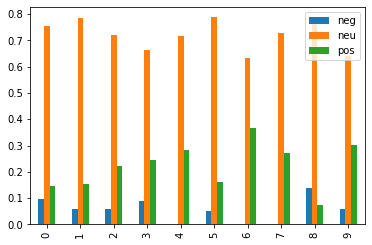

In [23]:
df_model[['neg', 'neu', 'pos']][:10].plot(kind = 'bar');

In [36]:
X= (df_model[['Compound_multiplied']])
y = (df_model['Predicted_change_price'])

In [37]:
X.shape

(1933, 1)

In [38]:
y.shape

(1933,)

In [19]:
#from sklearn.model_selection import train_test_split 
#X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=42)

In [20]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False)

### Train - Test split - not needed
The x_train and y_train is taken from the original data from 03/2016-06/2016
The x_test and y_test is the data from 28 days during March 2019

Remove the last row for each cashtag in all_data dataframe (=training data), since its 'Predicted_change_stock' is Na

In [21]:
# Remove the last row for each cashtag, since its 'Predicted_change_stock' is NaN
#df_model = df_model[np.isfinite(df_model['Predicted_change_price'])]
#df_model = df_model[np.isfinite(df_model['Buy/Sell'])]

#x_train = np.array(df_model[['Compound_multiplied']]) #
#y_train = np.array(df_model[['Buy/Sell']])

#x_test = np.array(df_model[['Compound_multiplied']])
#y_test = np.array(df_model[['Buy/Sell']])

In [25]:

#from sklearn.model_selection import train_test_split, GridSearchCV
#x = np.array(df_model['Compound_multiplied_scaled']) #
#y = np.array(df_model['Buy/Sell'])

# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Support Vector Machines (SVM) with different kernels
kernel = 'linear'
To be noted! SVM normally works better with scaled data, i.e. features e.g. between [0,1]. This is because it tries to maximize the distance between the separating plane and the support vectors. If one feature (i.e. one dimension in this space) has very large values, it will dominate the other features when calculationg the distance. However, since this analysis only uses one feature, the "Compound_multiplied", scaling will not be needed.

In [31]:
svm_linear = SVC( kernel = 'linear')
svm_linear.fit(X_train, y_train.ravel())

ValueError: The number of classes has to be greater than one; got 1 class

#### Accuracy for 'linear' after cross validation

###  Naive Bayes

- Please note! A MinMaxScaler is needed to get the features in the range MultinomialNB requires.

In [36]:
scaler = MinMaxScaler() 
X_minmax = scaler.fit_transform(X_train)

mnb = MultinomialNB()

#### Accuracy after cross validation 

In [37]:
mnb_cv = cross_val_score(mnb, X_minmax, y_train.ravel(), cv=10) 
mnb_cv.mean()

1.0